## 1. Multi-class Classification

### 1.1 Load and Plot data

In [1]:
# import library
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from sklearn.linear_model import LogisticRegression

# Load MATLAB files
import scipy.io

%matplotlib inline

In [2]:
data = scipy.io.loadmat('data/ex3data1.mat')
print(type(data))
print(len(data))
print(data)

<class 'dict'>
5
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}


In [3]:
X,y = data['X'],data['y'].ravel().reshape(-1,1)

# Add constant for intercept
X = np.column_stack((np.ones((data['X'].shape[0],1)), X))
print(X.shape)
print(y.shape)

(5000, 401)
(5000, 1)


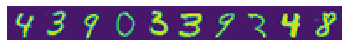

In [4]:
# Randomly select 10 numbers to plot
rand_indices = np.random.choice(X.shape[0], 10)
sel = X[rand_indices,1:]
plt.imshow(sel.reshape(-1,20).T)
plt.axis('off');

### 1.2 Implementation

#### 1.2.1 Regularized Logistic Regression

Logistic Regression has hypothesis:<br>
$$h_\theta(x) = g(\theta^Tx) $$

where:<br>
$$g(z) = \frac{1}{1 + e^{-z}}$$

In [5]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

Regularized Cost Function:
<br><br>
$$J(\theta) = \frac{1}{m} \sum_{i=1}^m 
[-y^{(i)}log(h_\theta (x^{(i)})) - (1 - y^{(i)})log(1-h_\theta (x^{(i)}))]
+ \frac{\lambda}{2m}  \sum_{j=1}^n \theta_j^2$$
<br>
Vectorized Cost Function:
$$J(\theta) = -\frac{1}{m}[y^T\cdot log(g(X\theta)) + (1 - y)^T \cdot log(1 - g(X\theta)]
+ \frac{\lambda}{2m}  \sum_{j=1}^n \theta_j^2$$

In [6]:
def lrcostFunctionReg(theta, reg, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    J = -1 / m * (np.log(h).T.dot(y) + np.log(1 - h).T.dot(1 - y)) + reg/(2*m)*np.sum(np.square(theta[1:]))
    #reg/(2 * m)*theta[1:].T.dot(theta[1:])  
    #The above regularized part of cost function computate the same result, but the format is ndarray not scalar
    return J[0][0]

Gradient:
<br><br>
$$\frac{\delta J}{\delta \theta_j} = \frac{1}{m}\sum_{i=1}^m((h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}) \;\;\;\;\;  \text{for j = 0}$$
<br>
$$\frac{\delta J}{\delta \theta_j} = \frac{1}{m}\sum_{i=1}^m((h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}) + \frac{\lambda}{m}\theta_j \;\;\;\;\;  \text{for j >= 1}$$

In [7]:
def lrgradientReg(theta, reg, X, y):
    theta = theta.reshape(-1,1)
    m = y.size
    h = sigmoid(X.dot(theta))
    temp = theta
    temp[0] = 0
    grad = np.zeros(theta.shape)
    grad = (1/m) * X.T.dot(h - y) + (reg / m) * temp
    return(grad.flatten())

Testing the costfunction and gradient

In [8]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)
# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)
# test values for the labels
y_t = np.array([1, 0, 1, 0, 1]).reshape(-1,1)
# test value for the regularization parameter
lambda_t = 3

In [9]:
J = lrcostFunctionReg(theta_t, lambda_t, X_t, y_t)
grad = lrgradientReg(theta_t, lambda_t, X_t, y_t)
print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]')

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


#### 1.2.2 One-vs-all Classification

In [10]:
def oneVsAll(X, y, num_labels, lambda_):
    m,n = X.shape
    all_theta = np.zeros((num_labels, n)) # 10 * 401
    for c in range(num_labels):
        initial_theta = np.zeros((n,1))
        res = scipy.optimize.minimize(lrcostFunctionReg,
                                     initial_theta,
                                     (lambda_, X, (y == c+1)),
                                     jac = lrgradientReg, method = None,
                                     options = {'maxiter':50})
        all_theta[c] = res.x
    return all_theta

In [11]:
# 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10
lambda_ = 0.1
theta = oneVsAll(X, y, num_labels, lambda_) # 10 * 401

#### 1.2.3 One-vs-all Prediction

In [12]:
def predictOneVsAll(all_theta, features):
    probs = sigmoid(X.dot(all_theta.T))
    # np.args Returns the indices of the maximum values along an axis
    # python use zero-index, plus 1
    p = np.argmax(probs, axis = 1)+1
    return p

In [13]:
pred = predictOneVsAll(theta, X)
accuracy = np.sum(pred == y.ravel())/y.size
print('Training set accuracy: {}%'.format(accuracy*100))

Training set accuracy: 93.24%


### 1.3 Multi-class Logistic Regression with scikit-learn

In [14]:
mclg = LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear', multi_class = 'ovr')
# Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
mclg.fit(X[:,1:],y.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
pred2 = mclg.predict(X[:,1:])
accuracy2 = np.sum(pred2 == y.ravel())/y.size
print('Training set accuracy: {}%'.format(accuracy2*100))

Training set accuracy: 96.5%


## 2. Neural Networks

In [16]:
weights = scipy.io.loadmat('data/ex3weights.mat')
print(weights.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])


In [17]:
theta1, theta2 = weights['Theta1'], weights['Theta2']
print('theta1: ', theta1.shape)
print('theta2: ', theta2.shape)

theta1:  (25, 401)
theta2:  (10, 26)


In [18]:
def predictnn(theta1, theta2, features):
    z2 = sigmoid(features.dot(theta1.T))
    a2 = np.column_stack((np.ones((features.shape[0],1)),z2))
    
    a3 = sigmoid(a2.dot(theta2.T))
    return np.argmax(a3, axis = 1)+1  

In [19]:
pred3 = predictnn(theta1, theta2, X)
accuracy3 = np.sum(pred3 == y.ravel())/y.size
print('Training set accuracy: {}%'.format(accuracy3*100))

Training set accuracy: 97.52%
